In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.integrate import odeint
from scipy import interpolate as interp

In [26]:
#set constants
global adv_BCL_no_flux, adv_BCR_no_flux, diff_BCL_no_flux, diff_BCR_no_flux 
global cL,cR,PL,PR
global alpha
global cinterp
global eps
global coupling_strength
global k1 
global k2
global k3
k1=1.
k2=1.
k3=1.
alpha=4.
eps=0.
coupling_strength=1.

def get_P(c):
    return np.power(c,alpha)

def u2(y,u):
    u1=u[1]
    u0=u[0]
    uw=get_uw(y)
    u2=k1*cinterp(y)*(u0-uw)+u0*np.power(y,-2.)
    #print(cinterp(y))
    return np.vstack([u1,u2])

def ubc(ua,ub):
    return np.array([ua[0],ub[1]])

def get_uw(y):
    return -y*(y-1)#y*np.exp(y,5*y**2/0.02)####-1./3.*y**3.

def get_vw(y):
    return y*(y-1.)

def get_u(y,c):
    global cinterp
    cinterp=interp.interp1d(y,c) #make interpolation object from the concentrations
    ug=[-y*(y-1.),-.1*(.5*y-1.)] 
    u=solve_bvp(u2,ubc,y,ug,verbose=0)
    u=u.sol(y)[0]
    return u

def get_vE(y,c):
    u=get_u(y,c)
    uw=get_uw(y)
    return k3*c*(u-uw)
    
def dcdt(c,t):
    dcdt_adv=np.zeros(len(c)) #concentration advective part 
    dcdt_diff=np.zeros(len(c)) #concentration diffusive part 
    v=np.zeros(len(c))
    #v+=get_vW(y)
    v+=get_vE(y,c)*y #this accounts for the r
    #advection interior
    for ii in range(1,len(c)-1):
        if v[ii]<=0:
            dcdt_adv[ii]=(c[ii+1]*v[ii+1]-c[ii]*v[ii])/delta
        elif v[ii]>0:
            dcdt_adv[ii]=(c[ii]*v[ii]-c[ii-1]*v[ii-1])/delta
    #BCL:
    if v[0]<=0:
        dcdt_adv[0]=(v[1]*c[1]-c[0]*v[0])/delta
    else:
        dcdt_adv[0]=dcdt_adv_BCL(v[0],c[0])
    #BCR:
    if vw[-1]>=0:
        dcdt_adv[-1]=(v[-1]*c[-1]-c[-2]*v[-2])/delta
    else:
        dcdt_adv[-1]=dcdt_adv_BCR(v[-1],c[-1])
    #non linear diffusion interior
    P=get_P(c)*y/k2 #this accounts for the r
    dcdt_diff[1:-1]=(P[:-2]-2.*P[1:-1]+P[2:])/delta**2.
    #BCL
    dcdt_diff[0]=dcdt_diff_BCL(P[1],P[0])
    #BCR
    dcdt_diff[-1]=dcdt_diff_BCR(P[-1],P[-2])

    #linear diffusion interior
    dcdt_diff[1:-1]+=eps*(c[:-2]-2.*c[1:-1]+c[2:])/delta**2.
    #BCL
    dcdt_diff[0]+=eps*dcdt_diff_BCL_lin(c[1],c[0])
    #BCR
    dcdt_diff[-1]+=eps*dcdt_diff_BCR_lin(c[-1],c[-2])
    #return sum 
    
    return -(dcdt_adv-dcdt_diff)/y

def dcdt_adv_BCL(vw0,c0):
    if adv_BCL_no_flux==1:
        #no flux condition
        return vw0*c0/delta
    else:
        #fixed C condition
        return (vw0*c0-vwL*cL)/delta

def dcdt_adv_BCR(vw1,c1):
    if adv_BCR_no_flux==1:
        #no flux condition 
        return -vw1*c1/delta
    else:
        #fixed C condition 
        return (vwR*cR-vw1*c1)/delta

def dcdt_diff_BCL(P1,P0):
    if diff_BCL_no_flux==1:
        return (P1-P0)/delta**2
    else:
        return (PL-2*P1+P0)/delta**2

def dcdt_diff_BCR(P1,P2):
    if diff_BCR_no_flux==1:
        return -(P1-P2)/delta**2
    else:
        return (PR-2*P1+P2)/delta**2
    
def dcdt_diff_BCL_lin(C1,C0):
    if diff_BCL_no_flux==1:
        return (C1-C0)/delta**2
    else:
        return (cL-2*C1+C0)/delta**2

def dcdt_diff_BCR_lin(C1,C2):
    if diff_BCR_no_flux==1:
        return -(C1-C2)/delta**2
    else:
        return (cR-2*C1+C2)/delta**2
    
def odeint_substepper(c0,t,dM):#reduces output
    dt=t[1]-t[0]
    C=np.zeros((len(t),len(c0)))
    C[0]=c0
    t_int=np.linspace(0,dM*dt,int(dM))
    for ii in range(1,len(t)):
        temp=odeint(dcdt,C[ii-1],t_int)
        C[ii]=temp[-1]
    return C

In [3]:
#y=np.linspace(0,1)
#ug=[get_uw(y),-0.1*np.ones(len(y))]
#sol=solve_bvp(u2,ubc,y,ug,verbose=1)
#y_plot=np.linspace(0,1,100)
#u_plot=sol.sol(y_plot)
#plt.plot(y_plot,u_plot[0])
#plt.plot(y_plot,u_plot[1])
#c=np.ones(len(y))*1.*1*(-np.tanh(y*20)+1)
#vE=get_vE(y,c)
#plt.plot(y,vE)
#plt.show()

In [31]:
#ygrid 
L=1.
delta=0.05
N=int(L/delta)-1
y=np.linspace(delta,L-delta,N)
#advective velocity
vw=1*y*(y-1)
#vw=-y*np.exp(-.5*y**2)
#settingup the time stepping

cinf=0.1
Um=np.max(np.abs(vw))
dt=delta/Um#**2/(4*4*cinf**3)

T=50.
dM=10. #substep size 
M=T/dt
print(M)
t=np.linspace(0,T+dt,int(M/dM))
print(dt)
print(len(t))
#boundary conditions 
adv_BCL_no_flux=1
adv_BCR_no_flux=1
diff_BCL_no_flux=1
diff_BCR_no_flux=0
cR=cinf
PR=get_P(cinf)

c0=cinf*np.ones(N)

C=odeint_substepper(c0,t,dM)


250.0
0.2
24


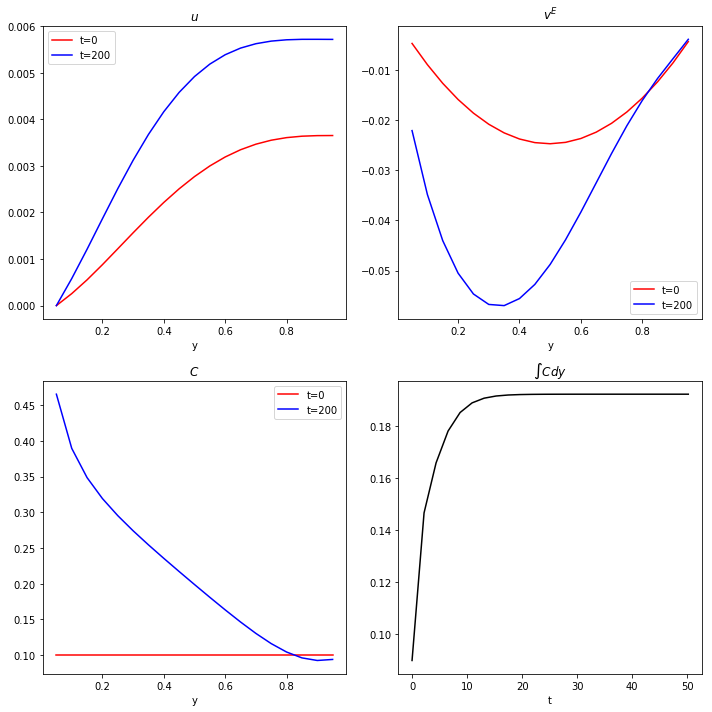

In [32]:
#X=np.load('coupled_u0=0.npy')
#C,t,y=X

vE0=get_vE(y,C[0])
vE1=get_vE(y,C[-1])
uW=get_uw(y)
u0=vE0/C[0]+uW
u1=vE1/C[-1]+uW

plt.figure(0,figsize=(10,10,),facecolor='white')
#plt.plot(y,uW,'k')
plt.subplot(2,2,1)
plt.title('$u$')
plt.plot(y,u0,'r',label='t=0')
plt.plot(y,u1,'b',label='t=200')
plt.xlabel('y')
plt.legend()
plt.subplot(2,2,2)
plt.title('$v^E$')
plt.plot(y,vE0,'r',label='t=0')
plt.plot(y,vE1,'b',label='t=200')
plt.xlabel('y')
plt.legend()
plt.subplot(2,2,3)
plt.title('$C$')
plt.plot(y,C[0],'r',label='t=0')
plt.plot(y,C[-1],'b',label='t=200')
plt.xlabel('y')
plt.legend()

plt.subplot(2,2,4)
M=np.trapz(y=C,x=y,axis=1)
plt.plot(t,M,'k-')
plt.xlabel('t')
plt.title('$\int C dy$')

plt.tight_layout()
plt.show()

24
10


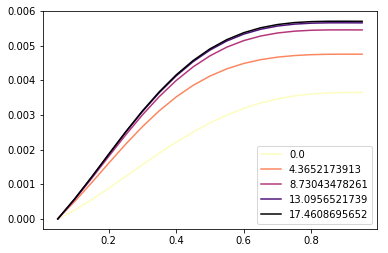

In [37]:
print(len(t))
T=np.min(np.where(t>20))
print(T)
tsamp=range(0,T,2)
U=np.zeros((len(tsamp),len(y)))
for ii in range(0,len(tsamp)):
    U[ii]=get_vE(y,C[tsamp[ii]])/C[tsamp[ii]]+uW
tsamp_col=np.linspace(0,1,len(tsamp))
for ii in range(0,len(tsamp)):
    plt.plot(y,U[ii,:],color=plt.cm.magma_r(tsamp_col[ii]),label=t[tsamp[ii]])
plt.legend()
plt.show()

24
10


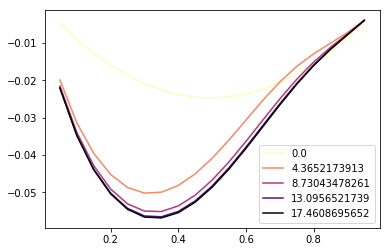

In [38]:
print(len(t))
T=np.min(np.where(t>20))
print(T)
tsamp=range(0,T,2)
U=np.zeros((len(tsamp),len(y)))
for ii in range(0,len(tsamp)):
    U[ii]=get_vE(y,C[tsamp[ii]])
tsamp_col=np.linspace(0,1,len(tsamp))
for ii in range(0,len(tsamp)):
    plt.plot(y,U[ii,:],color=plt.cm.magma_r(tsamp_col[ii]),label=t[tsamp[ii]])
plt.legend()
plt.show()

24
10


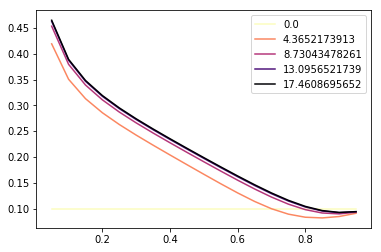

In [39]:
print(len(t))
T=np.min(np.where(t>20))
print(T)
tsamp=range(0,T,2)
U=np.zeros((len(tsamp),len(y)))
for ii in range(0,len(tsamp)):
    U[ii]=C[tsamp[ii]]
tsamp_col=np.linspace(0,1,len(tsamp))
for ii in range(0,len(tsamp)):
    plt.plot(y,U[ii,:],color=plt.cm.magma_r(tsamp_col[ii]),label=t[tsamp[ii]])
plt.legend()
plt.show()

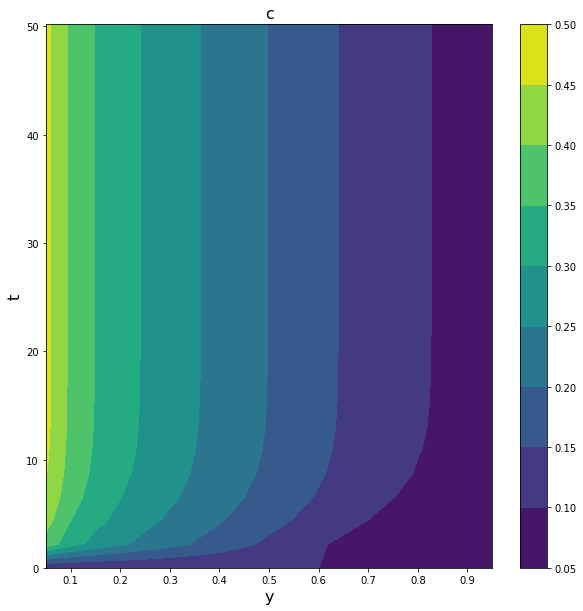

In [40]:
plt.figure(figsize=(10,10),facecolor='white')
plt.contourf(y,t,C)
plt.title('c',fontsize=16)# with $v^E \\neq 0$',fontsize=16)
plt.colorbar()
plt.ylabel('t',fontsize=16)
plt.xlabel('y',fontsize=16)
plt.show()